In [3]:
import sys
sys.path.insert(0, '../scripts/')
from helper_functions import convert_census_to_postcode

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

import geopandas as gpd

from scipy.interpolate import interp1d

output_dir = '../data/curated/'


<h3> Preparation for forecasting </h3>

In [4]:
properties_df = pd.read_csv("../data/curated/properties_processed.csv", index_col=0)
properties_df['Postcode'] = properties_df['Postcode'].astype(str)

# read in census dataframes
census_df = pd.read_csv("../data/curated/census_data.csv")
sa2_postcode_map = pd.read_csv("../data/curated/sa2_postcode_mapping_2021.csv")

In [5]:
census_df_postcode_agg = convert_census_to_postcode(census_df, sa2_postcode_map, 'mean_no_zero')

Median Rental Prices

In [7]:
median_rent = properties_df.groupby(["Postcode"])["Cost"].median()


In [8]:
median_rent.to_csv(f'{output_dir}median_rental_postcode.csv')

postcode_2021    3003.0
Name: 2, dtype: float64


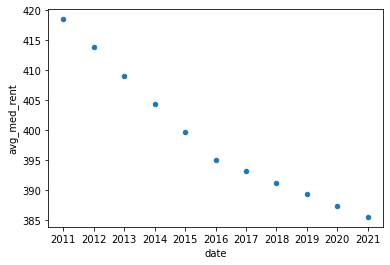

In [28]:
impute_features = ['tot_population', 'avg_med_mortg_rep', 'avg_med_person_inc', 'avg_med_rent', 'avg_med_hh_inc', 'tot_avg_hh_size']
init_years = [11, 16, 21]
new_years = list(range(11, 22))


for i in [2]:
    data = census_df_postcode_agg.iloc[i]
    #print(census_df_postcode_agg.iloc[i])

    # interpolation 
    interpolated_dict = dict()
    interpolated_dict['date']= [f'20{year}' for year in new_years]

    for feature in impute_features:
        init_y = data[[f'{feature}_{init_years[0]}', f'{feature}_{init_years[1]}', f'{feature}_{init_years[2]}']].tolist()
        #print(init_y)

        interp_func = interp1d(init_years, init_y)
        new_y = list(interp_func(new_years))
        #print(new_y)

        interpolated_dict[feature] = new_y

    # creation of new dataframe
    interpolated_df = pd.DataFrame(interpolated_dict)
    
    print(data[['postcode_2021']])
    interpolated_df.plot.scatter(x='date', y='avg_med_rent')

    # model
    interpolated_df['date'] = pd.to_datetime(interpolated_df['date'])
    interpolated_df = interpolated_df.set_index('date')
    interpolated_df = interpolated_df.asfreq('YS')
    interpolated_df = interpolated_df.sort_index()


    break 